In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from IPython.display import display, Markdown

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [ ]:
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(f"Dataset shape: {df.shape}")

Dataset shape: (7043, 21)


### EDA

In [33]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [34]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = "coerce")
df_clean = df.copy()
df_clean["TotalCharges"].isna().sum()

11

The **TotalCharges** column contained 11 missing values.  
This happens because these customers have a tenure of 0 or 1 months and have not yet been billed. Therefore, imputing them with 0 is consistent with the context of the data.


In [35]:
df["TotalCharges"] = df["TotalCharges"].fillna(0)

Text(0.5, 1.0, 'Churn distribution')

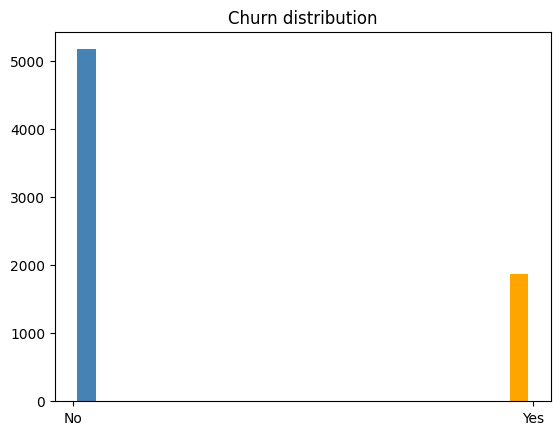

In [36]:
plt.hist([df[df["Churn"] == "No"]["Churn"], df[df["Churn"] == "Yes"]["Churn"]],
        color = ["steelblue", "orange"])
plt.title("Churn distribution")

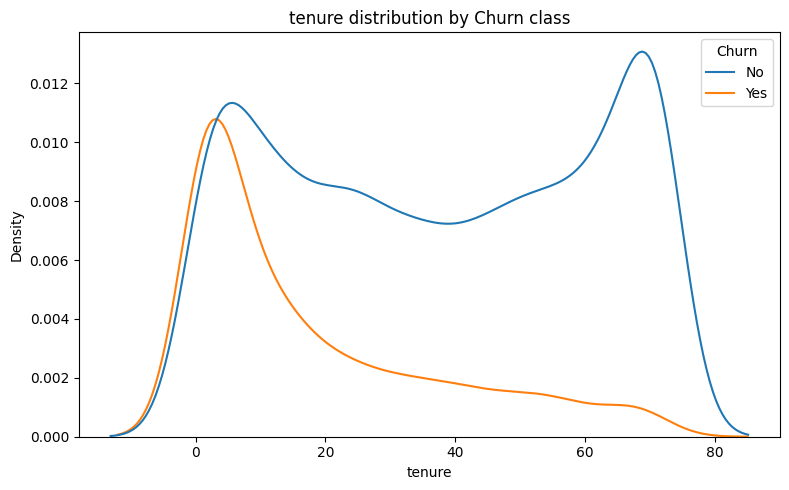

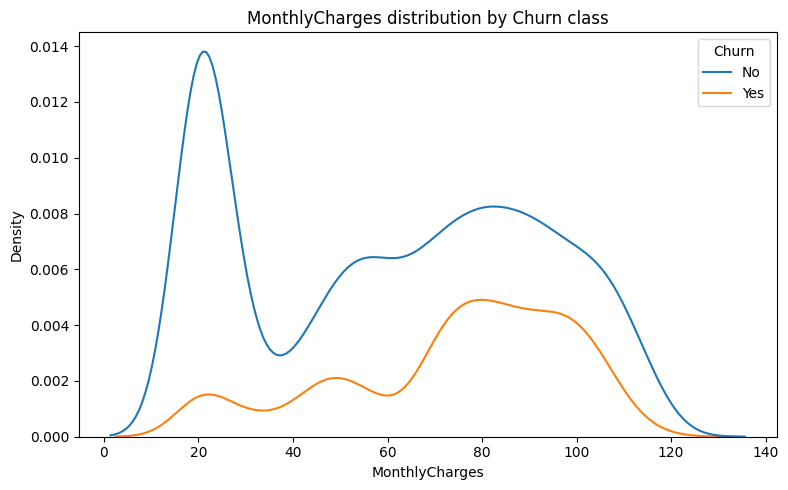

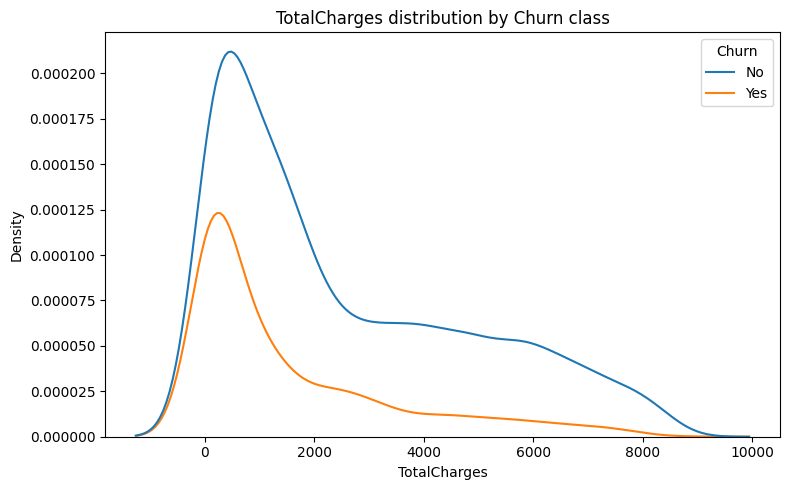

In [37]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
for col in num_cols:
    plt.figure(figsize = (8, 5))
    sns.kdeplot(
        data = df,
        x = col,
        hue = "Churn"
    )
    plt.title(f"{col} distribution by Churn class")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

The **KDE plots** show how the distribution of numerical features varies between churners and non-churners. We can gain valuable insights from these plots: the Yes class tends to have lower tenure and greater monthly charges.

In [38]:
gender_map = {'Female': 0, 'Male': 1}

yes_no_map = {'No': 0, 'Yes': 1}
yes_no_cols = ["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]

multiplelines_map = {'No phone service': -1, 'No': 0, 'Yes': 1}

internetservice_map = {'No': -1, 'DSL': 0, 'Fiber optic': 1}

internet_services_map = {'No internet service': -1, 'No': 0, 'Yes': 1} #onlinesecurity, onlinebackup, deviceprotection,techsupport,streaming services
internet_services_cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

contract_map = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}

paymentmethod_map = {'Electronic check': 0, 'Mailed check': 1, 'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3}


df_clean['gender'] = df_clean['gender'].map(gender_map)

for col in yes_no_cols:
    df_clean[col] = df_clean[col].map(yes_no_map).astype('int')
df_clean["MultipleLines"] = df_clean["MultipleLines"].map(multiplelines_map).astype('int')

df_clean["InternetService"] = df_clean["InternetService"].map(internetservice_map).astype('int')

for col in internet_services_cols:
    df_clean[col] = df_clean[col].map(internet_services_map).astype('int')
    
df_clean['Contract'] = df_clean['Contract'].map(contract_map).astype('int')
df_clean['PaymentMethod'] = df_clean['PaymentMethod'].map(paymentmethod_map).astype('int')

We took the effort of manually encoding categorical variables instead of using automatic encoding (provided by sklearn) to be able to **interpret** the model's decisions on those features later.

In [39]:
df_clean.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,-1,0,0,...,0,0,0,0,0,1,0,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,1,...,1,0,0,0,1,0,1,56.95,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,0,0,1,...,0,0,0,0,0,1,1,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,-1,0,1,...,1,1,0,0,1,0,2,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,0,70.70,151.65,1


Text(0, 0.5, 'Churn rate')

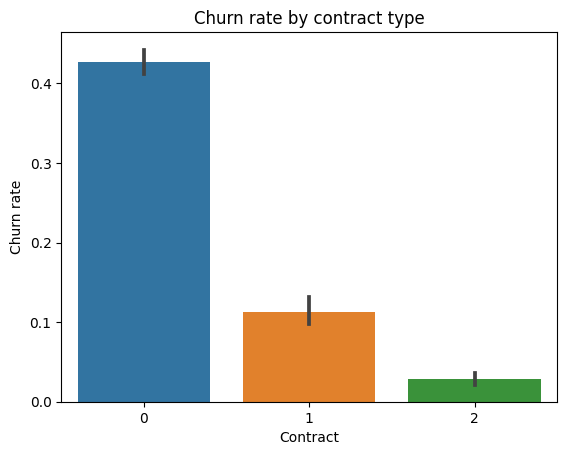

In [40]:
sns.barplot(
    data = df_clean,
    x = "Contract",
    y = "Churn",
    estimator = "mean",
)
plt.title("Churn rate by contract type")
plt.ylabel("Churn rate")

We can see that customers with a month-to-month contract tend to churn more than **40%** of the time.

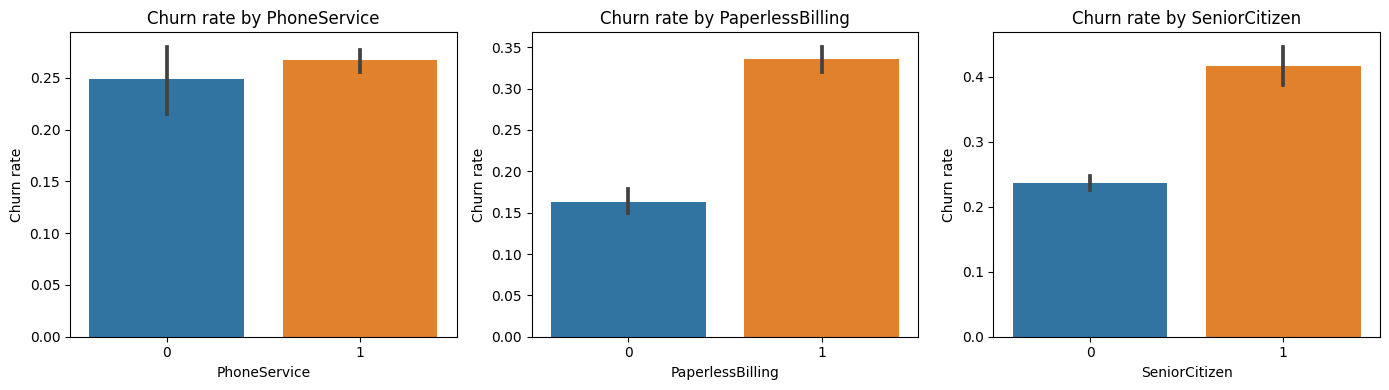

In [42]:
cols = ["PhoneService", "PaperlessBilling", "SeniorCitizen"]
fig, axes = plt.subplots(1, len(cols), figsize = (14, 4))
for ax, col in zip(axes, cols):
    sns.barplot(
        data = df_clean,
        x = col,
        y = "Churn",
        estimator = "mean",
        ax = ax
    )
    ax.set_title(f"Churn rate by {col}")
    ax.set_ylabel("Churn rate")
plt.tight_layout()
plt.show()

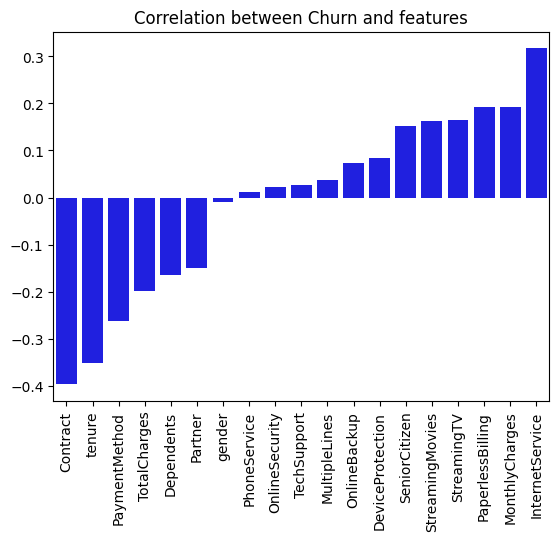

In [43]:
df_corr = df_clean.select_dtypes(include = [np.number]).corr()
churn_corr = df_corr["Churn"].drop("Churn")
churn_corr = churn_corr.sort_values()
sns.barplot(x = churn_corr.index,
           y = churn_corr.values,
           color = "blue")
plt.title("Correlation between Churn and features")
plt.xticks(rotation = 90)
plt.show()

We calculated the correlation between Churn and the other features using Pearson's method:
* Tenure is **negatively correlated** to the target, meaning higher value is associated with less churn probability
* Gender **doesn't have any correlation** to the target
* InternetService is **strongly positively correlated** to the target

In [44]:
X = df_clean.drop(["Churn", "customerID"], axis = 1)
y = df_clean["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42, test_size = 0.2)

In [45]:
from xgboost import XGBClassifier
clf = XGBClassifier(n_estimators = 125, learning_rate = 0.03 ,random_state = 42, eval_metric = 'logloss')
#clf = XGBClassifier(n_estimators = 100)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=125,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

We trained an **XGBoost classifier**, a powerful gradient boosting algorithm widely used on tabular prediction tasks. It's now time to evaluate it on the test data and inspect how different decision thresholds affect performance.

In [46]:
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba >= 0.5, 1, 0)
display(Markdown("### Classification Report | 0.5 threshold\n```text\n" + classification_report(y_test, y_pred) + "\n```"))

### Classification Report | 0.5 threshold
```text
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409

```

Even though the overall accuracy is fairly high (0.80), and recall for the non-churn class is strong (0.89), the model struggles to identify churners.  
Since churn prediction is a cost-sensitive problem, **recall for the positive class (churn = 1)** is much more important.  
At the default 0.5 threshold, this recall is only **0.54**, meaning the model misses around half of the customers who churn.

In [47]:
y_pred = np.where(y_pred_proba >= 0.3, 1, 0)
display(Markdown("### Classification Report | 0.3 threshold\n```text\n" + classification_report(y_test, y_pred) + "\n```"))

### Classification Report | 0.3 threshold
```text
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1035
           1       0.54      0.76      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409

```

By lowering the decision threshold, the recall for churners increases from 0.54 to **0.76**, meaning the model successfully identifies far more customers who are at risk.  
The trade-off is a drop in precision for class 1, which is expected: we catch more true churners at the cost of more false positives.  
In many real business settings, this trade-off is acceptable, since contacting a non-churner is usually less costly than missing a true churner.


# Confusion matrix

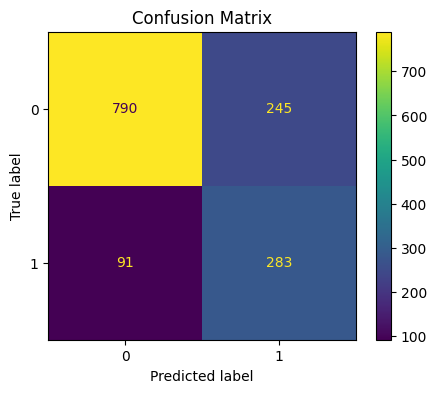

In [48]:
cm = confusion_matrix(y_test, y_pred)
cm_plot = ConfusionMatrixDisplay(cm, display_labels = [0, 1])

fig, ax = plt.subplots(figsize=(5,4))
cm_plot.plot(ax=ax)
ax.set_title("Confusion Matrix")
plt.show()

## Explainability

Here I explore the key factors driving the model’s churn predictions.  
Using explainability techniques, I show which features influence the model the most and how they affect the output.

### Feature importances
The bar plot below shows the global feature importances learned by XGBoost.

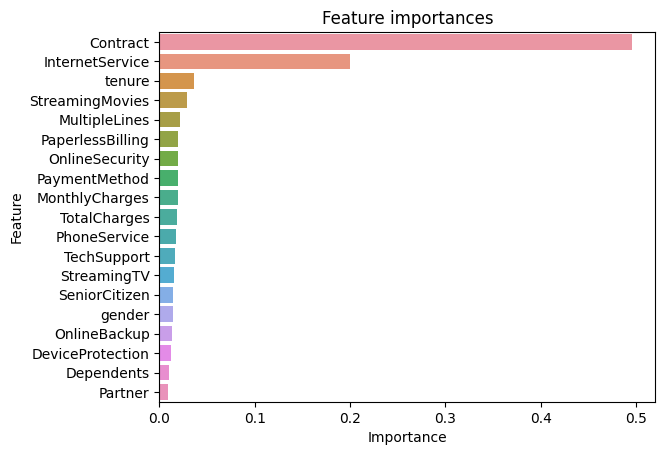

In [49]:
df_importances = pd.DataFrame({"Importance" : clf.feature_importances_, "Feature" : X_train.columns})
df_importances = df_importances.sort_values(by = "Importance", ascending = False)

sns.barplot(data = df_importances,
           x = "Importance",
           y = "Feature")
plt.title("Feature importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

The **type of contract** stands out as the most predictive feature. Following, there are the type of internet service and tenure.

### Partial Dependence Plots

Feature importances show which features matter the most, but they do not describe the **direction** or **shape** of their influence.  
Partial Dependence Plots illustrate how changes in a feature affect the predicted churn probability.

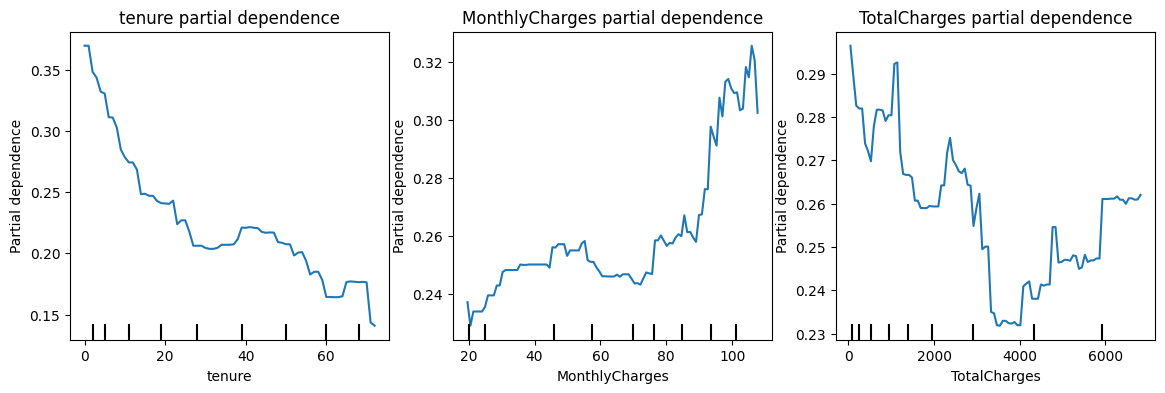

In [50]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(1, len(num_cols), figsize = (14, 4))
for ax, col in zip(ax, num_cols):
    disp = PartialDependenceDisplay.from_estimator(clf, X_test, [col], ax = ax)
    ax.set_title(f"{col} partial dependence")
plt.show()

Interpreting the partial dependence plots:
* **MonthlyCharges** shows a generally positive partial dependence: as monthly costs increase, the predicted probability of churn also increases. Customers who pay more each month tend to leave.
* **TotalCharges** displays a less smooth relationship, but the overall trend is negative: customers who have paid more in total (often those with longer histories) are less likely to churn.
* **Tenure** shows the clearest pattern: churn probability decreases strongly as tenure increases. Long-term customers are way less likely to leave compared to new ones.


### SHAP Force Plot for a single prediction

Feature importances and PDPs help interpret the model globally, but they don't explain individual predictions.  
Here, we select a customer from the test set and display a SHAP **force plot** to show how every feature contributes to the model's output.


In [51]:
import shap
row_data = X_test.sample(random_state = 40)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(row_data)

print(f"Prediction for this row: {clf.predict_proba(row_data)[0, 1]}")

Prediction for this row: 0.7174781560897827


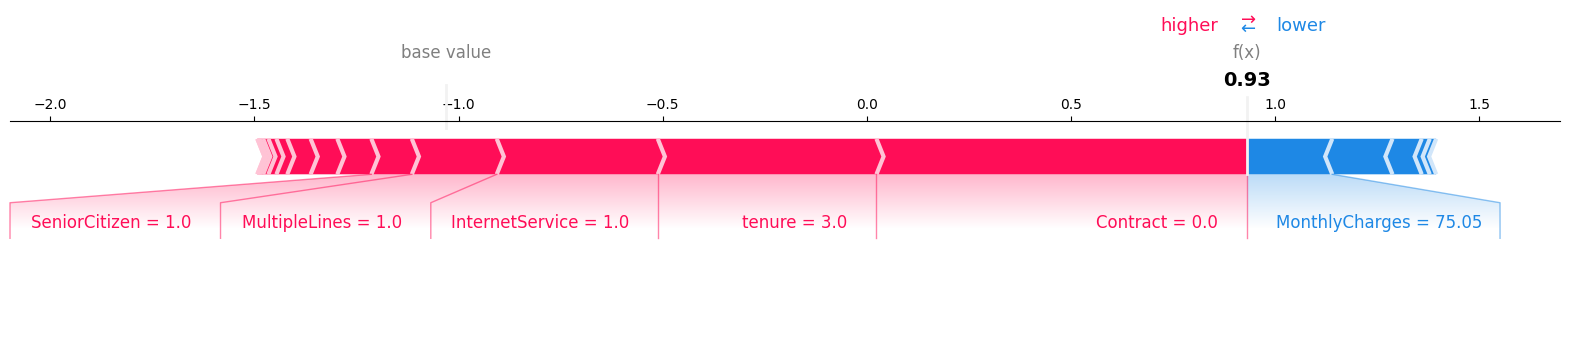

Actual class: [1]


In [52]:
shap.force_plot(explainer.expected_value, shap_values, row_data, matplotlib = True)
print(f"Actual class: {y_test[row_data.index].values}")

### Interpretation of this specific prediction

In this example, the model predicts a high probability of churn.
The SHAP force plot shows which features pushed the prediction upward (toward churn) and which pushed it downward:

* Fiber optic (InternetService = 1) and the Month-to-Month contract (Contract = 0) are strong **positive** contributors to churn. This is a typical churn pattern: customers with flexible contracts and high-cost service types tend to leave more frequently.

* The customer also has very **low tenure** (3.0), which increases the churn likelihood. New customers are more prone to leaving the contract.

* Above average MonthlyCharges (around 75) **lowers** the churn prediction.

Together, these factors push the model strongly toward predicting churn for this particular individual.

## SHAP summary plot

The SHAP summary plot offers a **global**, intuitive visualization of the most important features, and how they drive the model's predictions. It clearly shows if changes in value increase or decrease the probability of churn.

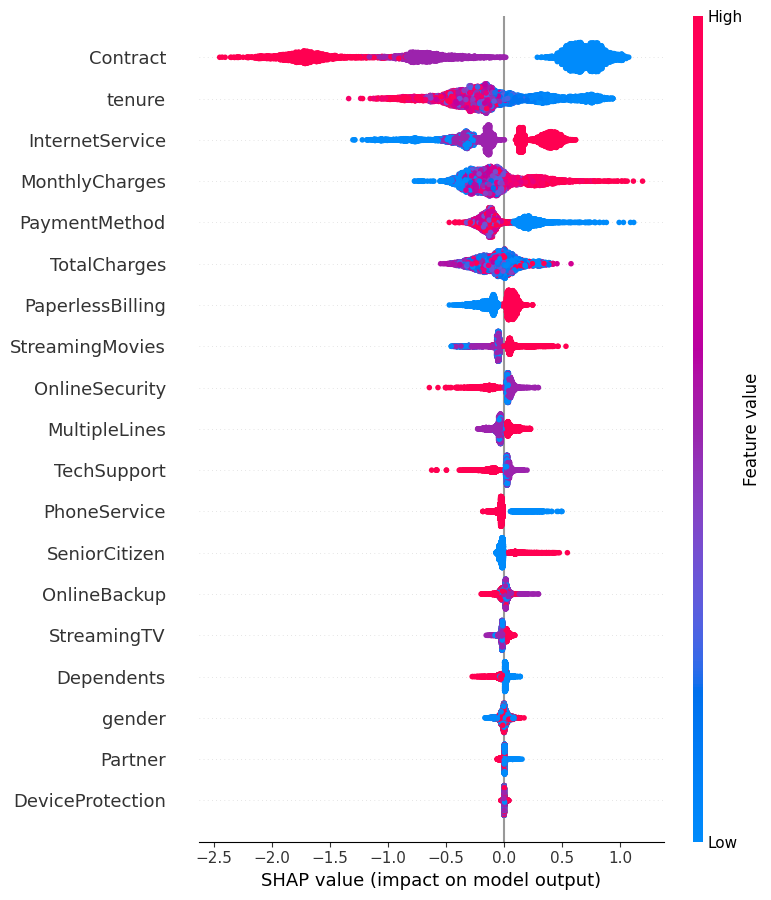

In [53]:
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

### SHAP summary plot analysis
* **Contract** is the feature with the largest overall impact on the model’s predictions. Red points correspond to 2-year contracts, purple to 1-year, and blue to month-to-month. The plot shows that longer contracts (red and purple) tend to push the prediction toward lower churn, while month-to-month contracts push it toward higher churn. This is confirmed by the business intuition that customers on flexible contracts are more likely to leave.   
* For **InternetService**, we see that high feature values (red points, representing fiber-optic internet) contribute positively to churn. Instead, customers with DSL or no internet service (blue points) push towards no churn. It could be useful for this business to investigate problems with the fiber-optic service.
* **TotalCharges** shows a mix of colors grouped around similar SHAP values, making its effect harder to interpret. This makes sense because TotalCharges depends on both how long a customer has been with the company and how much they pay per month, so by itself it doesn’t give a clear signal.
Looking at MonthlyCharges, it displays a much clearer pattern: as charges increase (going from blue to red), SHAP values also increase. This means higher monthly fees are directly associated with higher churn risk.
* The features near the bottom of the plot, such as gender, Partner, Dependents, and DeviceProtection, have SHAP values clustered **around zero**. This means that these variables have little to no impact on the model’s predictions: no matter what their values is, they rarely push the prediction towards one specific direction.

### Conclusion
In this notebook, we built a model to predict whether customers will churn or not, with data from the Telco dataset:
* We **cleaned** the dataset
* We performed **EDA** (Exploratory Data Analysis)
* We **trained** a Gradient Boosting model and selected a threshold for prediction. While not perfect, it was able to correctly identify 3 out of 4 churners. 
* We employed feature importances, PDP plots and SHAP values, both for a single prediction and globally, to **interpret** the model's decisions. The model consistently associated high monthly charges with higher churn risk, along with low tenure.

Future work could focus on improving the model with feature engineering or additional customer data.